Jonathan Tang
<br>Small Air Carrier Data Analysis
<br>Linear Regression
<br>R

# Objective of the Proposed Research

This report will be exploring Small Air Carrier Statistics (Form 298C Traffic Data) from 1974-2002. The dataset is provided by the US Department of Transportation – Bureau of Transportation Statistics. We will be focusing on Schedule A-1 which provides a summary of air carrier activity per quarter, providing us information such as number of scheduled departures, revenue passenger miles, revenue ton miles, and more.


Our stakeholder is **Pacific Airlines**, a new airline that is planning to launch a fleet of small airplanes for commuter and freight purposes. As a new player in the game, they have commissioned us to analyze the data of the all public airlines have reported in order to see how much revenue they can expect to generate given the amount of aircraft departures, seats, miles, and hours they provide.

Therefore, we shall be cleaning, exploring, and adapting the dataset for our study. We will perform linear regressions between with the following:

**Independent variables**: Departures Performed, Available ton miles, Available seat miles, Aircraft miles, Aircraft hours, Available units
<br>**Dependent variables**: Revenue passenger miles, Revenue ton miles, Revenue unit miles, Units sold per flight, Load factor

Our goal is to predict the amount of revenue passenger miles and revenue ton miles that an airline can generate given the aforementioned independent variables. We believe this data will be useful for Pacific Airlines as they will have a model of how much revenue they can expect to generate based on the amount of departures, hours, and seats they offer. 

---

# Data Cleaning

**Note:** We will begin with data cleaning rather than data exploration, since we do not want inappropriate 0s and NAs to affect our calculations.

1. Firstly, we will import our dataset into variable `dataset`.

In [ ]:
# Imports our dataset to Colab
dataset <- read.csv("/content/T_FORM298C_A1.csv")

---

2. Next, we will remove the following columns that are of no interest to us: `Region`, `Carrier`, `Carrier_Entity`, `Sch_Departures`, and `Comp_Departures`. We will store this new dataframe into variable `dataset_v1`.

In [ ]:
# Removes columns 3, 4, 6, 7, and 9.
dataset_v1 <- dataset[,c(-3,-4,-6,-7,-9)]

---

3. Next, we will remove all rows which have no values entered for our independent and dependent variables, and store it into `dataset_v2`.

In [ ]:
# Removes any rows that have 0 as the value in the specified columns.
dataset_v2 <- dataset_v1[-which((dataset_v1$DEP_PERFORMED == 0)|(dataset_v1$AVAIL_TON_MILES	== 0)|(dataset_v1$AVAIL_SEAT_MILES	== 0)|(dataset_v1$REV_PAX_MILES	== 0)|(dataset_v1$REV_TON_MILES	== 0)|(dataset_v1$AIRCRAFT_MILES	== 0)|(dataset_v1$AIRCRAFT_HOURS	== 0)),]

---

4. Finally, we will remove all rows which have extreme outliers for our variable `Departures Performed`. 
<br>This is because of extreme values that interfere with our plots and regressions, as shown in the summary below.

In [ ]:
summary(dataset_v2$AIRCRAFT_MILES)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      120     61765    184713   1069943    691267 113463424 

Our lowest value, 120, is **1539 times smaller** than the median.
<br>Our highest value, 113463424, is **614 times larger** than the median.

*Many other values we observed are also many magnitudes smaller or larger than those within our interquartile range.*

* Upon this realization, we have decided to cut off the outliers at **lower than the 15th percentile** and **higher than the 85th percentile**.

* We decided not to use the lower than (1Q - 1.5 x IQR) and higher than (3Q + 1.5 x IQR) method due to it failing to filter out our lower outliers. Upon attempting (Q1 - 1.5 X IQR), we find that the cutoff is set to a negative number, meaning no lower outliers would be filtered out.

* We believe that we will be able to better suit our purpose of visualizing and performing regressions on the data by eliminating this noise.

In [ ]:
quantile(dataset_v2$AIRCRAFT_MILES, probs=.15)

15% 
33665

In [ ]:
quantile(dataset_v2$AIRCRAFT_MILES, probs=.85)

85% 
1510503

In [ ]:
dataset_v3 <- dataset_v2[(dataset_v2$AIRCRAFT_MILES>33665)&(dataset_v2$AIRCRAFT_MILES<1510502.75), ]

In [ ]:
dataset_v3[1:5,]

,YEAR,QUARTER,CARRIER_NAME,DEP_PERFORMED,AVAIL_TON_MILES,AVAIL_SEAT_MILES,REV_PAX_MILES,REV_TON_MILES,AIRCRAFT_MILES,AIRCRAFT_HOURS
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1974,3,"Antilles Air Boats, Inc.",8828,599364,4689150,3486593,365466,487288,3739
4,1974,3,Brandt Air,1859,42637,568016,154164,25295,62335,613
5,1974,3,"Allen Aviation, Inc.",1761,51270,440250,134350,13435,85450,1096
6,1974,3,"Air Midwest, Inc.",4751,495360,5453805,2696430,244462,437801,2228
7,1974,3,Amistad Airlines,385,31350,313500,164250,17322,57750,424


---

# Data Exploration

## 1. Rows and columns

Let us see how many rows and columns are contained in our dataset.

In [ ]:
# Find number of rows in our data.
nrow(dataset_v3)

# Find the number of columns in our data.
ncol(dataset_v3)

[1] 4070

[1] 10

As we can see, our cleaned dataset has 4070 rows x 10 columns.

---

## 2. Average

Let us find the average of all our variables of interest.

In [ ]:
# Store the means of our variables into a data frame.
means.matrix=matrix(c(mean(dataset_v3$DEP_PERFORMED), mean(dataset_v3$AVAIL_TON_MILES), mean(dataset_v3$AVAIL_SEAT_MILES), mean(dataset_v3$REV_PAX_MILES), mean(dataset_v3$REV_TON_MILES), mean(dataset_v3$AVAIL_SEAT_MILES), mean(dataset_v3$AIRCRAFT_HOURS)),nrow=1,)
means=as.data.frame(means.matrix)
colnames(means) <- c('DEP_PERFORMED','AVAIL_TON_MILES','AVAIL_SEAT_MILES','REV_PAX_MILES','REV_TON_MILES','AIRCRAFT_MILES','AIRCRAFT_HOURS')

# Print our means dataframe.
means

DEP_PERFORMED,AVAIL_TON_MILES,AVAIL_SEAT_MILES,REV_PAX_MILES,REV_TON_MILES,AIRCRAFT_MILES,AIRCRAFT_HOURS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3534.158,756128.8,5673009,2564247,315406.1,5673009,2522.411


The dataframe above shows the means of our independent and dependent variables, across 4070 rows of cleaned data.

---

## 3. Standard deviation

Let us find the standard deviation of our independent variables.

In [ ]:
# Store the standard deviations of our variables into a data frame.
stddev.matrix=matrix(c(sd(dataset_v3$DEP_PERFORMED), sd(dataset_v3$AVAIL_TON_MILES), sd(dataset_v3$AVAIL_SEAT_MILES), sd(dataset_v3$REV_PAX_MILES), sd(dataset_v3$REV_TON_MILES), sd(dataset_v3$AVAIL_SEAT_MILES), sd(dataset_v3$AIRCRAFT_HOURS)),nrow=1,)
stddev=as.data.frame(stddev.matrix)
colnames(stddev) <- c('DEP_PERFORMED','AVAIL_TON_MILES','AVAIL_SEAT_MILES','REV_PAX_MILES','REV_TON_MILES','AIRCRAFT_MILES','AIRCRAFT_HOURS')

# Print our standard deviations dataframe.
stddev

DEP_PERFORMED,AVAIL_TON_MILES,AVAIL_SEAT_MILES,REV_PAX_MILES,REV_TON_MILES,AIRCRAFT_MILES,AIRCRAFT_HOURS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3246.11,4037929,17393253,5892817,1329679,17393253,28441.95


The dataframe above shows the standard deviations of our independent and dependent variables, across 4070 rows of cleaned data.

---

## 4. Histogram & Max of Departures Performed

Let us view a histogram plot for our `Departures Performed` variable.

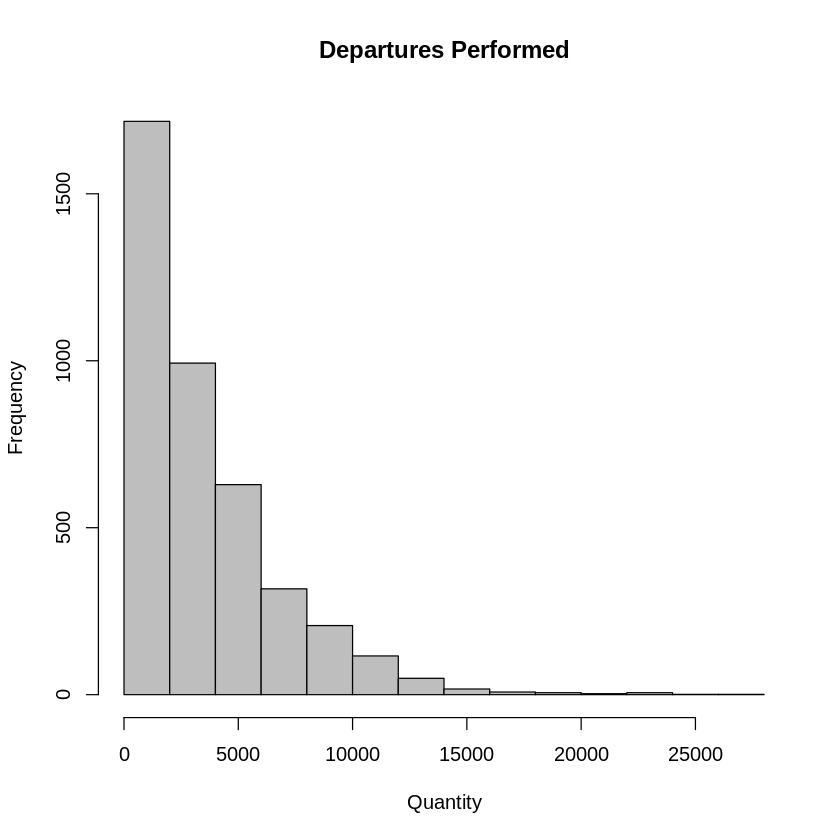

In [ ]:
# Plot a histogram of departures performed.
hist.dep.performed <- hist(dataset_v3$DEP_PERFORMED, freq=TRUE, col="grey", 
     xlab="Quantity", main="Departures Performed")

Next, let's find the highest value in this variable.

In [ ]:
# Find the maximum value of departures performed.
max(dataset_v3$DEP_PERFORMED)

[1] 26365

We can see that the plot is **right-skewed**, with most carrier companies having between **0-10,000** departures performed, while the highest amount is **26,365** departures performed.

---

# Adaptation

## Introduction & Method

We will be adding 3 additional calculated columns which will be useful information in our analysis.

However, before we do so, we would like to introduce a new metric:

**1 unit = 1 seat OR 1 ton**

To interpret a unit, consider an aircraft has 20 units available for sale on a typical flight. That means that they some combination of seats + tons available for sale, maybe 15 seats + 5 tons for example.

This will be important because in the Schedule A-1 form, when an airline company reports their aircraft miles, **they do not specify how many of those miles were sold to passengers versus cargo.** 

Therefore, we will essentially be combining passenger **AND** cargo business into 1 unit.

---

## 1. Revenue Unit Miles

The first new column will be `REV_UNIT_MILES`.

This is a dependent variable which equals:

**Number of units sold × Miles travelled**

*Revenue unit miles = (Revenue passenger miles + Revenue ton miles) / Aircraft miles*

In [ ]:
# Create a new vector by dividing available seat miles by aircraft miles, then store it into a variable.
REV_UNIT_MILES <- matrix(c(dataset_v3$REV_PAX_MILES + dataset_v3$REV_TON_MILES))

# Combine the new column to our dataset & store it into a new variable.
dataset_v4 <- cbind(dataset_v3,REV_UNIT_MILES)

In [ ]:
summary(dataset_v4$REV_UNIT_MILES)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     3356    280703    838031   2879653   3308337 250366975 

We can see that the median number of **revenue unit miles** is 838031.

---

## 2. Available units per flight

The second new column will be `AVAIL_UNITS`.

This will be an **independent variable** which measures the **average amount of available units per flight**.

It can be interpreted as the average of the sum of seats + tons available to purchase per flight. For example, if an airline has 10 available units, then it may have 5 seats + 5 tons for sale, or some other combination.

*Available units per flight = (Available Seat Miles + Available Ton Miles) / Aircraft Miles*

In [ ]:
# Create a new vector by dividing available seat miles by aircraft miles, then store it into a variable.
AVAIL_UNITS <- matrix(c((dataset_v4$AVAIL_SEAT_MILES + dataset_v4$AVAIL_TON_MILES)/dataset_v4$AIRCRAFT_MILES))

# Combine the new column to our dataset & store it into a new variable.
dataset_v5 <- cbind(dataset_v4,AVAIL_UNITS)

In [ ]:
summary(dataset_v5$AVAIL_UNITS)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.013     7.245     9.929    19.391    19.299 10868.000 

We can see that the median number of **available units** is 9.929.

---

## 3. Units sold per flight

The third new column will be `UNITS_SOLD`. 



This will be a **dependent variable** which measures the average number of **units sold per flight**.

It can be interpreted as the number of seats + number of tons that were purchased for a given flight. For example, an airline might average 20 units sold per flight, meaning they could have sold 15 seats + 5 tons or some other combination of the two.

**In general, it can show us the quantity of seats + tons *actually sold* per flight.**

*Units sold per flight = (Revenue Passenger Miles + Revenue Ton Miles) / Aircraft Miles*

In [ ]:
# Create a new vector by dividing revenue passenger miles by aircraft miles, then store it into a variable.
UNITS_SOLD <- matrix(c((dataset_v5$REV_PAX_MILES+dataset_v5$REV_TON_MILES)/dataset_v5$AIRCRAFT_MILES))

# Combine the new column to our dataset & store it into a new variable.
dataset_v6 <- cbind(dataset_v5,UNITS_SOLD)

In [ ]:
summary(dataset_v6$UNITS_SOLD)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0143    2.6328    4.9996    7.7831    8.8321 1494.9000 

We can see that the median number of **units sold** per flight was 4.9996.

---

## 4. Load Factor

The fourth new column will be `LOAD_FACTOR`.

This will be a dependent variable which measures the **percentage of available capacity sold to passengers or cargo**.

It can be interpreted as such: If an airline has 20 available seats but only sells 10 tickets, then it is at 50% load factor.

Airlines prefer having a **higher** load factor, as it raises revenues, mitigates fixed costs, and is more attractive to investors. 

A high load factor means that an airline is efficient at selling tickets and generating higher revenue.

*Load factor = (Revenue passenger miles + Revenue ton miles) / (Available seat miles + Available ton miles)*

In [ ]:
# Create a new vector by dividing revenue passenger miles by aircraft miles, then store it into a variable.
LOAD_FACTOR <- matrix(c((dataset_v6$REV_PAX_MILES+dataset_v6$REV_TON_MILES)/(dataset_v6$AVAIL_SEAT_MILES+dataset_v6$AVAIL_TON_MILES)))

# Combine the new column to our dataset & store it into a new variable.
dataset_v7 <- cbind(dataset_v6,LOAD_FACTOR)

---

## Combined dataset

Now that we've created the two additional columns and combined it to our dataset, let's see what the new dataframe looks like.

`dataset_v6`

In [ ]:
# Print the first 5 rows of the new dataset.
dataset_v7[1:5,]

,YEAR,QUARTER,CARRIER_NAME,DEP_PERFORMED,AVAIL_TON_MILES,AVAIL_SEAT_MILES,REV_PAX_MILES,REV_TON_MILES,AIRCRAFT_MILES,AIRCRAFT_HOURS,REV_UNIT_MILES,AVAIL_UNITS,UNITS_SOLD,LOAD_FACTOR
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1974,3,"Antilles Air Boats, Inc.",8828,599364,4689150,3486593,365466,487288,3739,3852059,10.852953,7.905097,0.7283821
4,1974,3,Brandt Air,1859,42637,568016,154164,25295,62335,613,179459,9.796310,2.878944,0.2938805
5,1974,3,"Allen Aviation, Inc.",1761,51270,440250,134350,13435,85450,1096,147785,5.752136,1.729491,0.3006694
6,1974,3,"Air Midwest, Inc.",4751,495360,5453805,2696430,244462,437801,2228,2940892,13.588742,6.717417,0.4943369
7,1974,3,Amistad Airlines,385,31350,313500,164250,17322,57750,424,181572,5.971429,3.144104,0.5265246


As we can see, we now have 4 additional columns for `Revenue unit miles`, `Available units per flight`, `Units sold per flight`, and `Load Factor`.

---

## Data Cleaning - Part 2

Now that we have all of the columns that we will be using, we will like to further clean our data by removing the outliers in the variable `UNITS_SOLD`. This is because there are some extreme values as shown in the summary below.

In [ ]:
summary(dataset_v7$UNITS_SOLD)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0143    2.6328    4.9996    7.7831    8.8321 1494.9000 

Our lowest value, 0.00143, is 3536 times smaller than the median.
<br>Meanwhile, our largest value, 1494, is 300 times larger than the median.

Upon further review of our data, we decided to cut off the upper outliers below the 15th percentile and above the 85th percentile.

In [ ]:
quantile(dataset_v7$UNITS_SOLD, probs=.15)

15% 
1.796977

In [ ]:
quantile(dataset_v7$UNITS_SOLD, probs=.85)

85% 
11.32068

In [ ]:
dataset_final <- dataset_v7[(dataset_v7$UNITS_SOLD>1.7969767077092)&(dataset_v7$UNITS_SOLD<11.3206816071303)&(dataset_v7$REV_UNIT_MILES>168383.5)&(dataset_v7$REV_UNIT_MILES<6192889.35)&(dataset_v7$AVAIL_UNITS<23.3706777604723), ]

We now have our cleaned dataset: `dataset_final`

In [ ]:
dataset_final[1:10,]

,YEAR,QUARTER,CARRIER_NAME,DEP_PERFORMED,AVAIL_TON_MILES,AVAIL_SEAT_MILES,REV_PAX_MILES,REV_TON_MILES,AIRCRAFT_MILES,AIRCRAFT_HOURS,REV_UNIT_MILES,AVAIL_UNITS,UNITS_SOLD,LOAD_FACTOR
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1974,3,"Antilles Air Boats, Inc.",8828,599364,4689150,3486593,365466,487288,3739,3852059,10.852953,7.905097,0.7283821
4,1974,3,Brandt Air,1859,42637,568016,154164,25295,62335,613,179459,9.796310,2.878944,0.2938805
6,1974,3,"Air Midwest, Inc.",4751,495360,5453805,2696430,244462,437801,2228,2940892,13.588742,6.717417,0.4943369
7,1974,3,Amistad Airlines,385,31350,313500,164250,17322,57750,424,181572,5.971429,3.144104,0.5265246
8,1974,3,Air Carolina,512,33280,302000,158100,17507,51200,696,175607,6.548438,3.429824,0.5237622
11,1974,3,"Brower Airways, Inc.",1386,83853,838992,402802,40280,104874,642,443082,8.799559,4.224898,0.4801261
13,1974,3,"Catalina Airlines, Inc.",2105,68202,682020,407232,40723,75780,595,447955,9.900000,5.911256,0.5970966
14,1974,3,"Air Catalina (Catalina Seaplanes, Inc.)",11281,241693,2416914,1604968,164360,268546,2330,1769328,9.900006,6.588547,0.6655094
18,1974,3,"Command Airways, Inc.",3762,669807,5655750,2036425,250327,434135,2287,2286752,14.570484,5.267375,0.3615100


---

# Descriptive Visualization

## 1. Scatter plot

Let's begin with a visualization of `Revenue Unit Miles` vs `Departures Performed`.

`Departures Performed` is an **independent variable**.
<br>`Revenue Unit Miles` is a **dependent variable**.

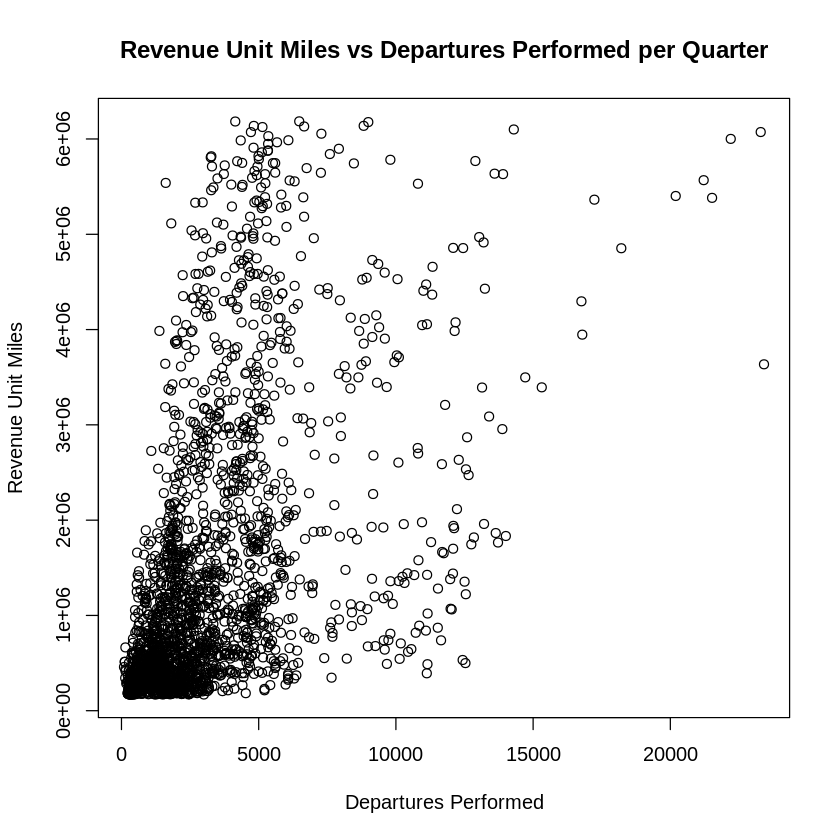

In [ ]:
# Form the scatter plot.
plot(dataset_final$DEP_PERFORMED, dataset_final$REV_UNIT_MILES, xlab='Departures Performed', ylab='Revenue Unit Miles', main='Revenue Unit Miles vs Departures Performed per Quarter')

Through the scatter plot, we can again that most points are clustered between 0 and 2,000 `Departures Performed`.

We can also see a positive correlation between `Departures Performed` and `Revenue Unit Miles` generated.

---

## 2. Histogram

Next, let us plot a histogram of `Units sold per flight`, a **dependent variable**.

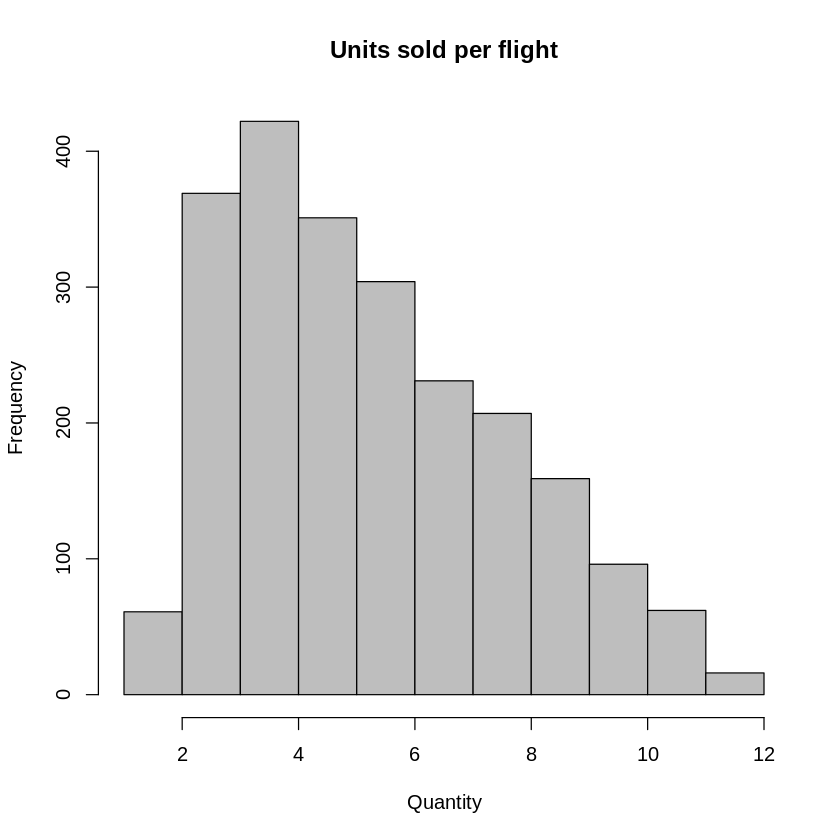

In [ ]:
# Plot a histogram of Units sold per flight.
hist(dataset_final$UNITS_SOLD, freq=TRUE, col="grey", 
xlab="Quantity", main="Units sold per flight")

In [ ]:
# Summary of Units Sold
summary(dataset_final$UNITS_SOLD)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.798   3.306   4.773   5.210   6.819  11.256 

The histogram shown above tells us that the amount of units sold is **right-skewed**, with the highest bar being between 3 and 4 units sold per flight.

---

## 3. Box plot

Next, let's explore a box plot visualization of `Available units per flight` and `Units sold per flight`.

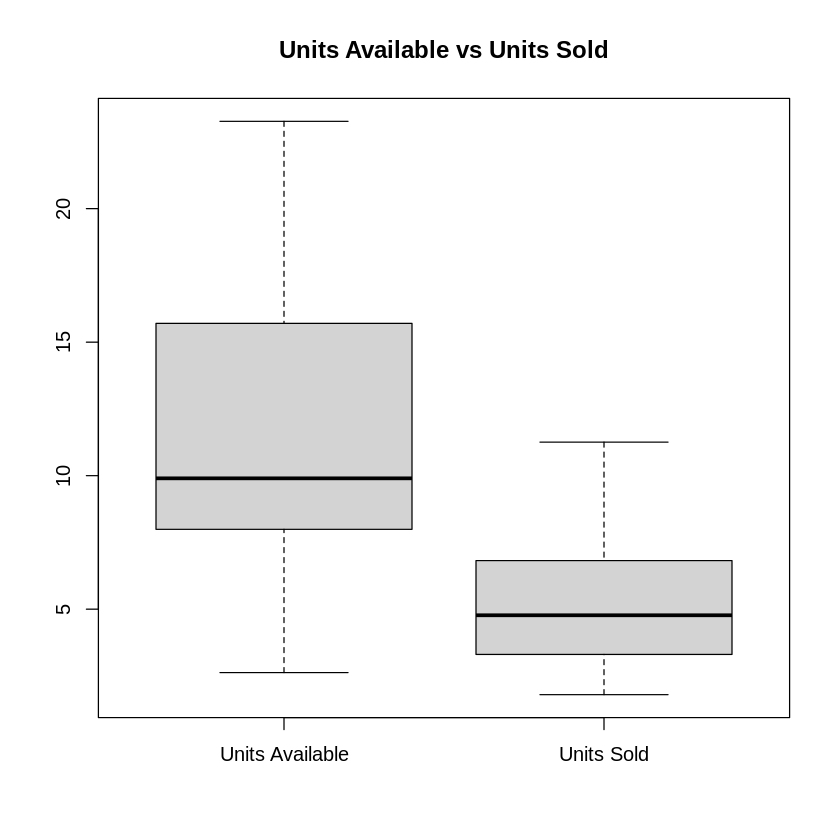

In [ ]:
boxplot(dataset_final$AVAIL_UNITS, dataset_final$UNITS_SOLD, horizontal=FALSE, names=c('Units Available', 'Units Sold'), main='Units Available vs Units Sold')

In [ ]:
# Summary of Available Units
summary(dataset_final$AVAIL_UNITS)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.625   7.991   9.900  11.509  15.704  23.270 

In [ ]:
# Summary of Units Sold
summary(dataset_final$UNITS_SOLD)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.798   3.306   4.773   5.210   6.819  11.256 

Here we can see a boxplot comparing `Units Available` and `Units Sold`. It makes sense that units available is consistently higher than units sold, with a median of 9.9 to a median of about 4.773.

**This shows that on average, about half of the available capacity (passengers or cargo) is sold.**

---

## 4. Bar Plot

Finally, let's explore a bar plot, which allows us to visualize each airline company as a bar. 

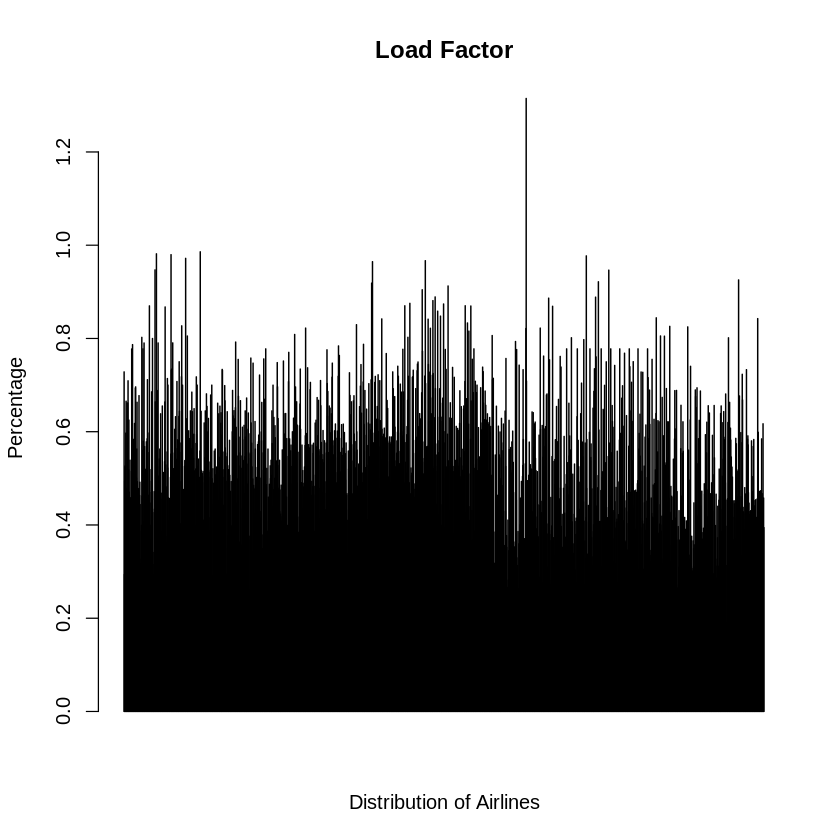

In [ ]:
barplot(dataset_final$LOAD_FACTOR, xlab='Distribution of Airlines', ylab='Percentage', main='Load Factor')

The bar plot helps us visualize how far apart some of the highest and lowest values are, as well as giving us a general feel of a centric value.

Interestingly, we can see that very vew airline companies are able to reach near 1.0 load factor, meaning full capacity on every single flight. Many of the values hover between 0.5-0.8 load factor.

In [ ]:
summary(dataset_final$LOAD_FACTOR)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.09626 0.36354 0.47075 0.47414 0.57560 1.31486 

---

# Explore Correlations

## 1. Aircraft Hours vs Aircraft Miles

Recall our **independent (exploratory)** variables:
* Departures Performed
* Available ton miles
* Available seat miles
* Available units per flight
* Aircraft miles
* Aircraft hours

Intuitively, we can understand that all of our independent variables are positively correlated with one another. For example, if an aircraft flew for more **hours**, then its **miles** should increase as well.

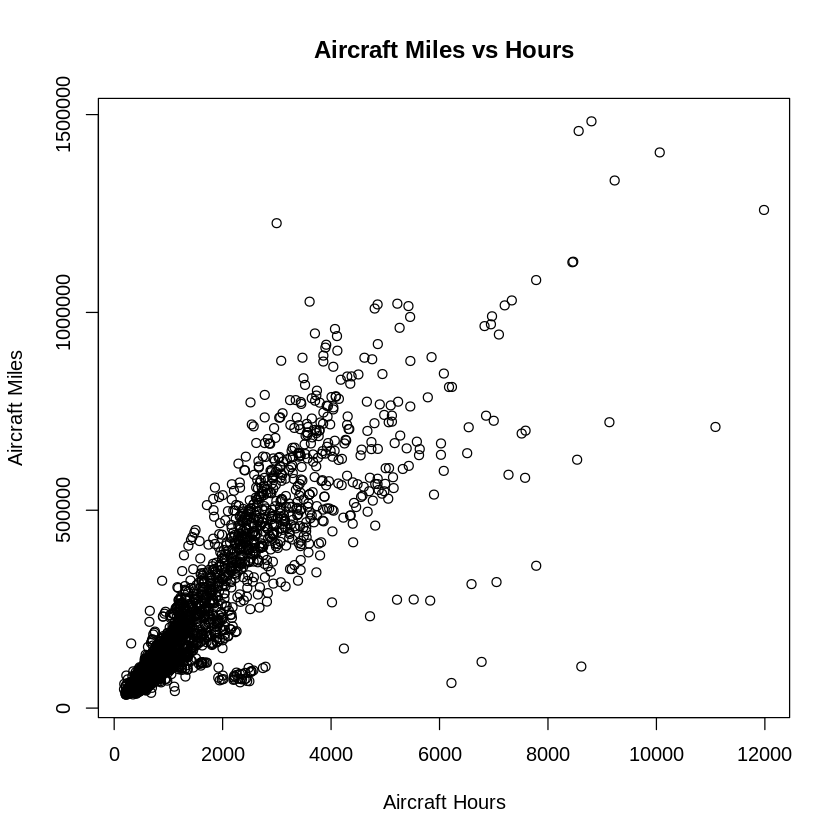

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AIRCRAFT_HOURS, dataset_final$AIRCRAFT_MILES, xlab='Aircraft Hours', ylab='Aircraft Miles', main='Aircraft Miles vs Hours')

Above, we can see a strong, positive linear correlation between the two variables. Likewise, we should also expect miles & hours to correlate to departures performed, available seat miles, and available ton miles as well, as they all scale with **quantity of service provided**.

---

## 2. Departures performed vs Available units for sale

How about `Available units per flight`? Recall that it is essentially the number of seats + number of tons up for sale. 

Does the amount of seats/tons an airline offers per flight have any correlation to the amount of flights it departs on?

Here, it doesn't seem that the two variables are explicitly connected, but it is possible that offering higher capacity in one flight is a more desired trait by buyers, especially for cargo.

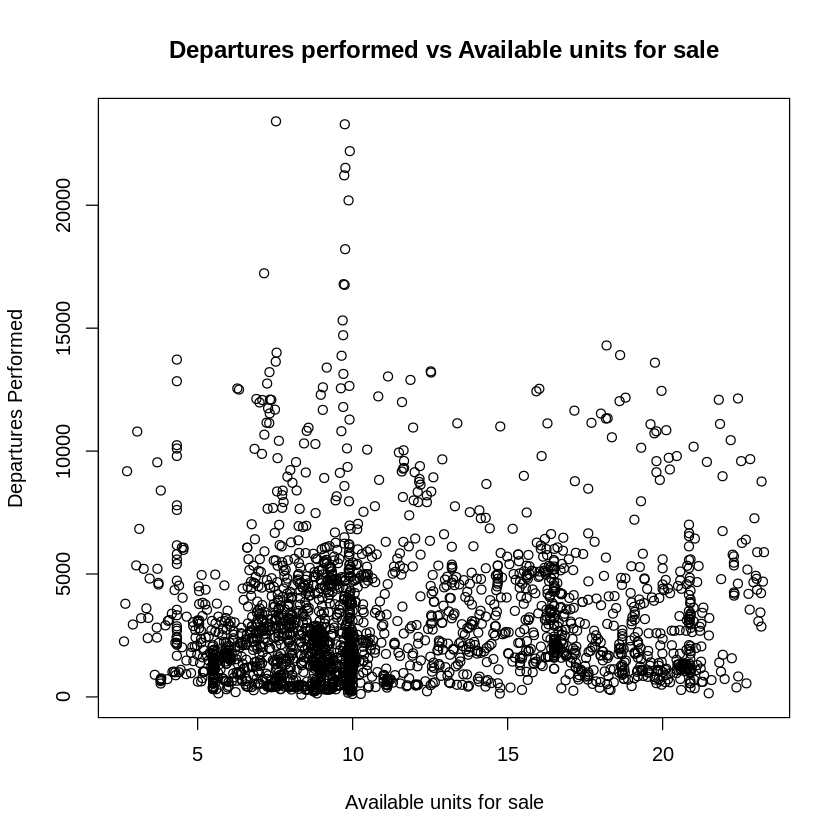

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AVAIL_UNITS, dataset_final$DEP_PERFORMED, xlab= 'Available units for sale', ylab= 'Departures Performed', main='Departures performed vs Available units for sale')

Interestingly, the `Available units for sale` and `Departures performed` seem to have weak to no correlation.

It seems that the amount of capacity per flight does not have much effect the amount of departures performed.  

---

# Response Variable

Recall our **dependent (response) variables**:

* Revenue passenger miles
* Revenue ton miles
* **Revenue unit miles**
* Units sold per flight
* Load factor

We would like to define these variables once again before we go into linear regressions.

---

**Revenue passenger miles** (RPM) is a commonly used industry metric that measures the number of miles traveled by paying passengers. It is the industry standard metric to gauge how much business an airline has generated.

This asks the question, why not just use the **raw revenue generated**?

The answer is because fare prices are usually unpredictable and unknown in advance, and different airlines often charge different fare prices. 

*This variance in price means that the company that "made the most money" might not have been the one that "provided the most service".*

Therefore, using RPM has been able to standardize how much business each airline is doing.

*Revenue passenger miles = Miles travelled x Paying Passengers*

---

**Revenue ton miles** measures how many tons were sold across how many miles. It is used to gauge the amount business an airline generated from freight.

*Revenue ton miles = Miles travelled x Tons sold*

---

**Revenue unit miles** is a term we coined for solely for this report. It combines **Revenue passenger miles** and **Revenue ton miles** by summing them, allowing us to view an airline company's performance in both passenger and cargo service combined.

*Revenue unit miles = Revenue seat miles + Revenue ton miles*

---

**Units sold per flight** is the average number of units (passengers + tons) per flight.

*Units sold per flight = (Revenue Passenger Miles + Revenue Ton Miles) / Aircraft Miles*

---

**Load factor** measures the percentage of available capacity sold to passengers or cargo. As mentioned earlier in the report, a higher load factor is more desirable by airlines and investors, as it generates more revenue and uses resources more efficiently.

*Load factor = (Revenue passenger miles + Revenue ton miles) / (Available seat miles + Available ton miles)*

---

# Simple Linear Regression

## 1. Revenue passenger miles vs Available seat miles

**Prediction:**
<br> How well can we predict the amount of `Revenue passenger miles` generated by an airline, given their `Available seat miles`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

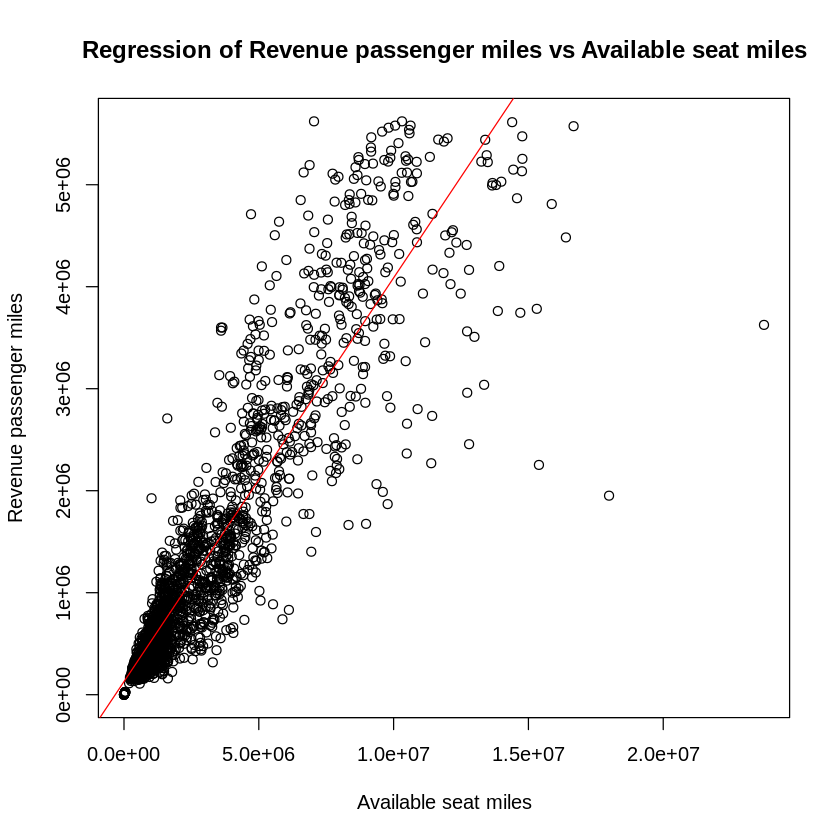

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AVAIL_SEAT_MILES, dataset_final$REV_PAX_MILES, main="Regression of Revenue passenger miles vs Available seat miles", xlab= "Available seat miles", ylab= "Revenue passenger miles")

# Perform the linear regression of y on x.
test1 <- lm(dataset_final$REV_PAX_MILES ~ dataset_final$AVAIL_SEAT_MILES, data=dataset_final)

# Add the regression line to the plot.
abline(test1, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test1)


Call:
lm(formula = dataset_final$REV_PAX_MILES ~ dataset_final$AVAIL_SEAT_MILES, 
    data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-5899842  -190507   -53107   142919  2717667 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.282e+05  1.554e+04   8.247 2.72e-16 ***
dataset_final$AVAIL_SEAT_MILES 3.959e-01  3.777e-03 104.819  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 538800 on 2276 degrees of freedom
Multiple R-squared:  0.8284,	Adjusted R-squared:  0.8283 
F-statistic: 1.099e+04 on 1 and 2276 DF,  p-value: < 2.2e-16


**Analysis:**

**Linear regression equation:**
<br>$y = 12820 + 0.3959x$


In [ ]:
median(dataset_final$AVAIL_SEAT_MILES)

[1] 1526924

For example, if an airline had 1,526,924 `Available seat miles`, their predicted `Revenue passenger miles` would be 617,329 in our model.

Judging by the scatterplot and regression line, we can see that `Available seat miles` and `Revenue passenger miles` have a **very strong positive linear correlation**. The adjusted r-squared value is 0.8283, meaning that 82.83% of the variance in the y-values is accounted for by the linear regression model.

This means that if as `Available seat miles` increases, `Revenue passenger miles` is highly likely to increase as well. This makes sense since both variables scale with miles travelled by the airline.

Therefore, we can **confidently** and **accurately** predict the `Revenue passenger miles` from `Available seat miles`.

---

## 2. Revenue ton miles vs Available ton miles

**Prediction:**
<br> How well can we predict the amount of `Revenue ton miles` generated by an airline, given their `Available ton miles`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

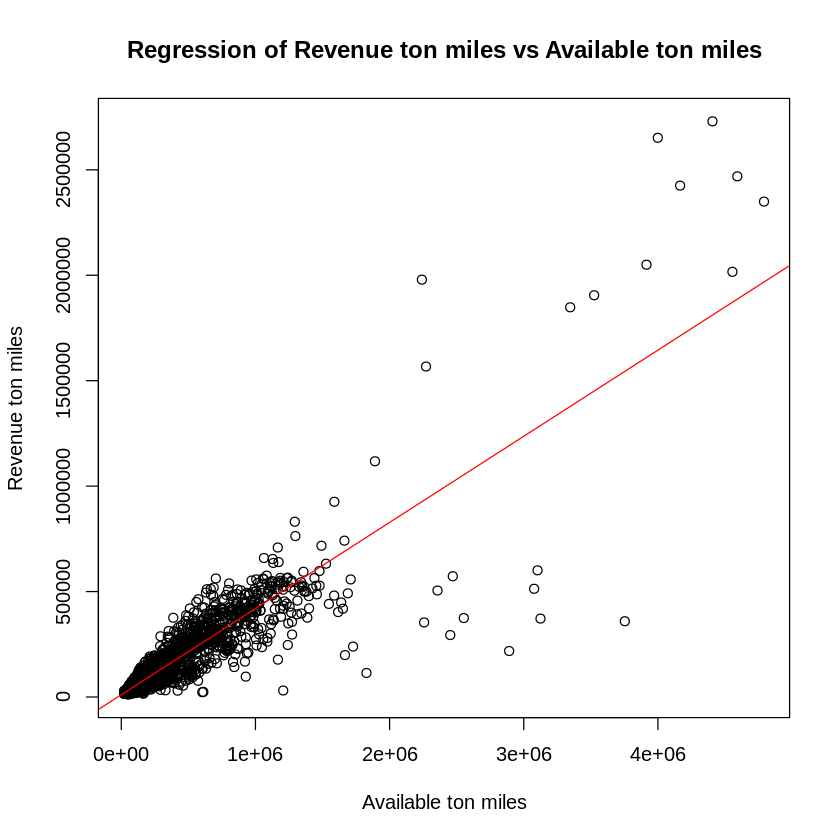

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AVAIL_TON_MILES, dataset_final$REV_TON_MILES, main="Regression of Revenue ton miles vs Available ton miles", xlab= "Available ton miles", ylab= "Revenue ton miles")

# Perform the linear regression of y on x.
test2 <- lm(dataset_final$REV_TON_MILES ~ dataset_final$AVAIL_TON_MILES, data=dataset_final)

# Add the regression line to the plot.
abline(test2, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test2)


Call:
lm(formula = dataset_final$REV_TON_MILES ~ dataset_final$AVAIL_TON_MILES, 
    data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-1184909   -16141    -1979    19669  1052945 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   1.077e+04  2.406e+03   4.475 8.03e-06 ***
dataset_final$AVAIL_TON_MILES 4.086e-01  4.333e-03  94.290  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 90710 on 2276 degrees of freedom
Multiple R-squared:  0.7962,	Adjusted R-squared:  0.7961 
F-statistic:  8891 on 1 and 2276 DF,  p-value: < 2.2e-16


**Analysis:**

**Linear regression equation:**
<br>$y = 1077 + 0.4086x$

In [ ]:
median(dataset_final$AVAIL_TON_MILES)

[1] 175792

Using our prediction model, if an airline had 175,792 `Available ton miles`, we predict that their `Revenue ton miles` would be 72,905.

Judging by the scatterplot and regression line, we can see that `Available ton miles` and `Revenue ton miles` have a **very strong positive linear correlation**. The adjusted r-squared value is 0.7961, meaning that 79.61% of the variance in the y-values is accounted for by the linear regression model.

This means that if as `Available ton miles` increases, `Revenue ton miles` is highly likely to increase as well. This makes sense since both variables scale with miles travelled.

Therefore, we can **confidently** and **accurately** predict the `Revenue ton miles` from `Available ton miles`.

---

## 3. Revenue unit miles vs Departures performed

**Prediction:**
<br> How well can we predict the amount of `Revenue unit miles` generated by an airline, given their `Departures performed`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

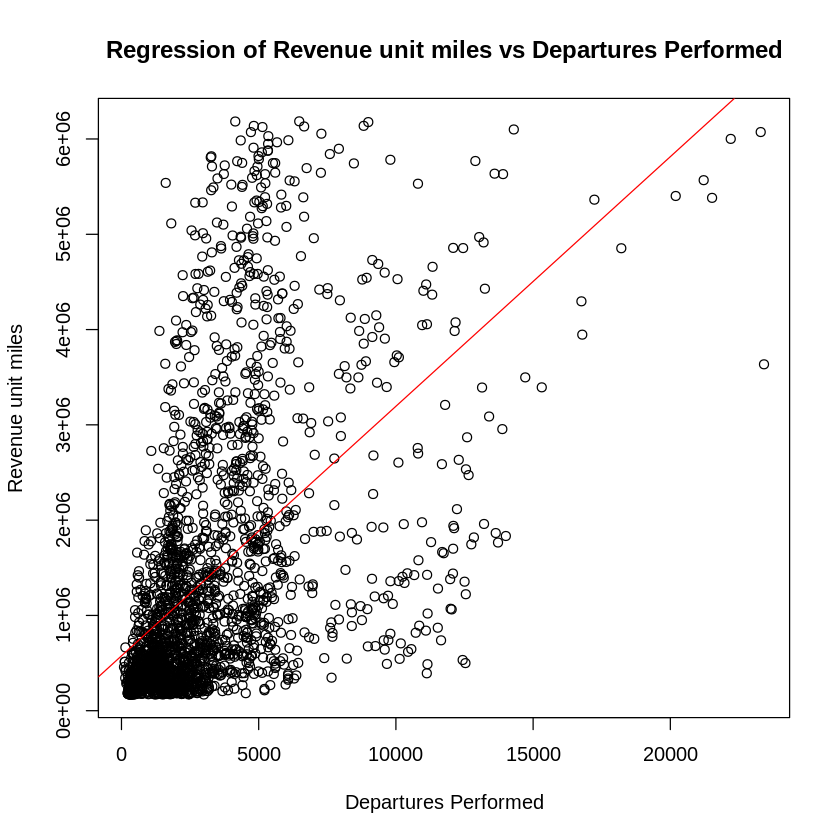

In [ ]:
# Plot the scatterplot.
plot(dataset_final$DEP_PERFORMED, dataset_final$REV_UNIT_MILES, main="Regression of Revenue unit miles vs Departures Performed", xlab= "Departures Performed", ylab= "Revenue unit miles")

# Perform the linear regression of y on x.
test3 <- lm(dataset_final$REV_UNIT_MILES ~ dataset_final$DEP_PERFORMED, data=dataset_final)

# Add the regression line to the plot.
abline(test3, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test3)


Call:
lm(formula = dataset_final$REV_UNIT_MILES ~ dataset_final$DEP_PERFORMED, 
    data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-3359204  -689849  -368732   381100  4541182 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 575686.89   38619.57   14.91   <2e-16 ***
dataset_final$DEP_PERFORMED    261.95       9.18   28.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1227000 on 2276 degrees of freedom
Multiple R-squared:  0.2635,	Adjusted R-squared:  0.2632 
F-statistic: 814.3 on 1 and 2276 DF,  p-value: < 2.2e-16


**Analysis:**

**Linear regression equation:**
<br>$y = 575686.89 + 261.95x$

In [ ]:
median(dataset_final$DEP_PERFORMED)

[1] 2346.5

Using our equation, if the `Departures performed` of an airline was 2346, then their predicted `Revenue unit miles` would be 1,190,352.

Here, we can see that `Departures Performed` and `Revenue unit miles` have a positive correlation, but it isn't very strong. The adjusted r-squared value is 0.2632, meaning that 26.32% of the variance in the y-values is accounted for by the linear regression model.

Given that Adjusted R-squared ranges from 0-1, this **is not** a particularly strong correlation. 

Therefore, while some level of correlation may exist between the two variables, we **cannot** confidently predict the `Revenue passenger miles` from `Available seat miles`.

---

## 4. Units sold per flight vs Available units

**Prediction:**
<br> How well can we predict the amount of `Units sold per flight` generated by an airline, given their `Available units`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

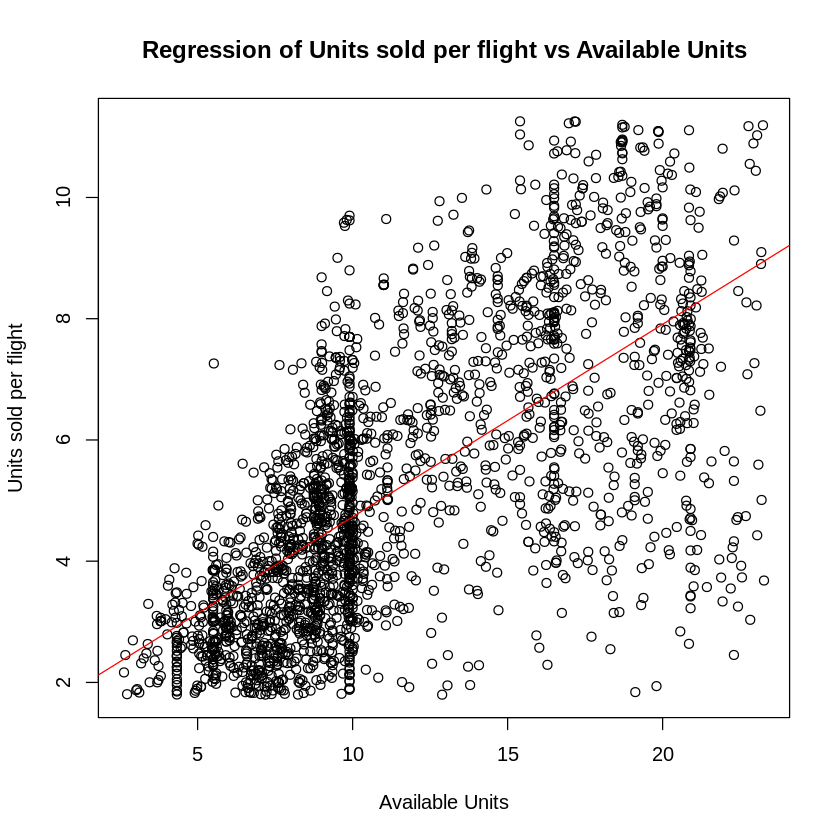

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AVAIL_UNITS, dataset_final$UNITS_SOLD, main="Regression of Units sold per flight vs Available Units", xlab= "Available Units", ylab= "Units sold per flight")

# Perform the linear regression of y on x.
test4 <- lm(dataset_final$UNITS_SOLD ~ dataset_final$AVAIL_UNITS, data=dataset_final)

# Add the regression line to the plot.
abline(test4, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test4)


Call:
lm(formula = dataset_final$UNITS_SOLD ~ dataset_final$AVAIL_UNITS, 
    data = dataset_final)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1864 -1.0765 -0.1125  1.1262  5.0018 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.551247   0.091758   16.91   <2e-16 ***
dataset_final$AVAIL_UNITS 0.317872   0.007341   43.30   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.708 on 2276 degrees of freedom
Multiple R-squared:  0.4517,	Adjusted R-squared:  0.4514 
F-statistic:  1875 on 1 and 2276 DF,  p-value: < 2.2e-16


**Analysis:**

**Linear regression equation:**
<br>$y = 1.551 + 0.318x$

In [ ]:
median(dataset_final$AVAIL_UNITS)

[1] 9.899998

Using our equation, if an airline had 9.9 `Available units`, then their predicted `Units sold` would be 4.7.

Here we can see that `Available units` and `Units sold per flight` have a **moderate positive correlation**. The adjusted r-squared value is 0.4514, meaning that 45.14% of the variance in the y-values is accounted for by the linear regression model.

This means that if as `Available units` increases, `Units sold per flight` is somewhat likely to increase as well. This makes sense since in order for higher amounts of units to be sold, the airline needs to make more units available for purchase to the consumer.

Given the moderate positive correlation, we can assume that overall when `Available units` increases, `Units sold per flight` will also **likely increase**, but we **cannot** confidently or accurately predict the `Units sold per flight` given the `Available units`.

---

## 5. Load factor vs Aircraft hours

**Prediction:**
<br> How well can we predict the amount of `Load factor` generated by an airline, given their `Aircraft hours`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

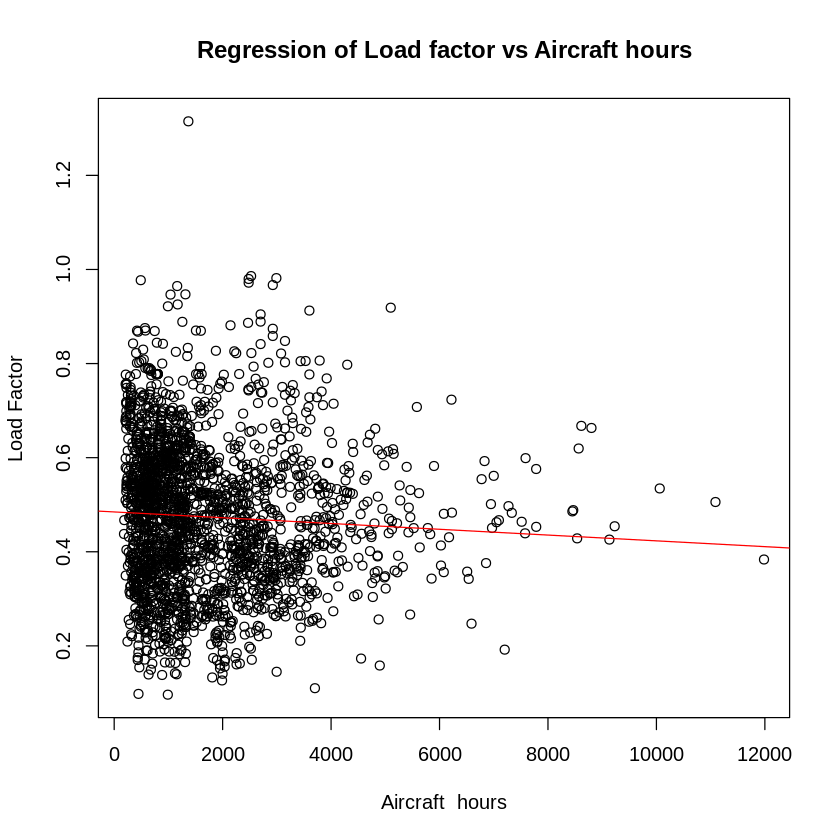

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AIRCRAFT_HOURS, dataset_final$LOAD_FACTOR, main="Regression of Load factor vs Aircraft hours", xlab= "Aircraft  hours", ylab= "Load Factor")

# Perform the linear regression of y on x.
test5 <- lm(dataset_final$LOAD_FACTOR ~ dataset_final$AIRCRAFT_HOURS, data=dataset_final)

# Add the regression line to the plot.
abline(test5, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test5)


Call:
lm(formula = dataset_final$LOAD_FACTOR ~ dataset_final$AIRCRAFT_HOURS, 
    data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38393 -0.10719 -0.00044  0.09805  0.83866 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   4.846e-01  5.066e-03  95.664  < 2e-16 ***
dataset_final$AIRCRAFT_HOURS -6.148e-06  2.301e-06  -2.672  0.00759 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1532 on 2276 degrees of freedom
Multiple R-squared:  0.003127,	Adjusted R-squared:  0.002689 
F-statistic:  7.14 on 1 and 2276 DF,  p-value: 0.007591


**Analysis:**

**Linear regression equation:**
<br>$y = 0.4846 + 0.000006148x$

In [ ]:
median(dataset_final$AIRCRAFT_HOURS)

[1] 1240.5

Using our model, if an airline had 1240.5 `Aircraft hours`, then their predicted `Load factor` would be 0.49.

Here, we can see a strange looking graph that looks messy with a near-horizontal regression line. We can gather that `Aircraft hours` and `Load factor` have a **weak/no linear correlation**. The adjusted r-squared value is 0.002689, meaning that 0.2689% of the variance in the y-values is accounted for by the linear regression model.

Given that Adjusted r-squared ranges from 0-1, this is an extremely low value which shows that the two variables have almost zero correlation and the relationship is random.

Therefore, we **cannot** confidently or accurately predict the `Revenue passenger miles` from `Available seat miles`.

---

## Comparisons between the SLRs


The simple linear regressions & their adjusted r-squared values we performed were the following:

1.   **Revenue passenger miles** vs **Available seat miles** | r2 = 0.8283
2.   **Revenue ton miles** vs **Available ton miles** | r2 = 0.7961
3.   **Revenue unit miles** vs **Departures performed** | r2 = 0.2632
4.   **Units sold per flight** vs **Available units** | r2 = 0.4514
5.   **Load factor** vs **Aircraft hours** | r2 = 0.002689









As we can see, the `Revenue passenger miles` vs `Available seat miles` had the highest r-squared value at 0.8283, showing the strongest positive correlation, and being our most **succcessful** simple linear regression.

On the other hand, `Load factor` vs `Aircraft hours` had an r-squared value of 0.002689, which was extremely low, showing almost zero correlation. Therefore, we would have to explore other potential variables or methods to predict `Load factor` in the future.

# Multiple Linear Regression

In [ ]:
# Import the scatterplot3d library to plot 3d scatterplots.
install.packages("scatterplot3d")
library(scatterplot3d)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## 1. Revenue passenger miles vs Available seat miles + Aircraft hours

**Prediction:**
<br> How well can we predict the amount of `Revenue passenger miles` generated by an airline, given their `Available seat miles` and `Aircraft hours`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

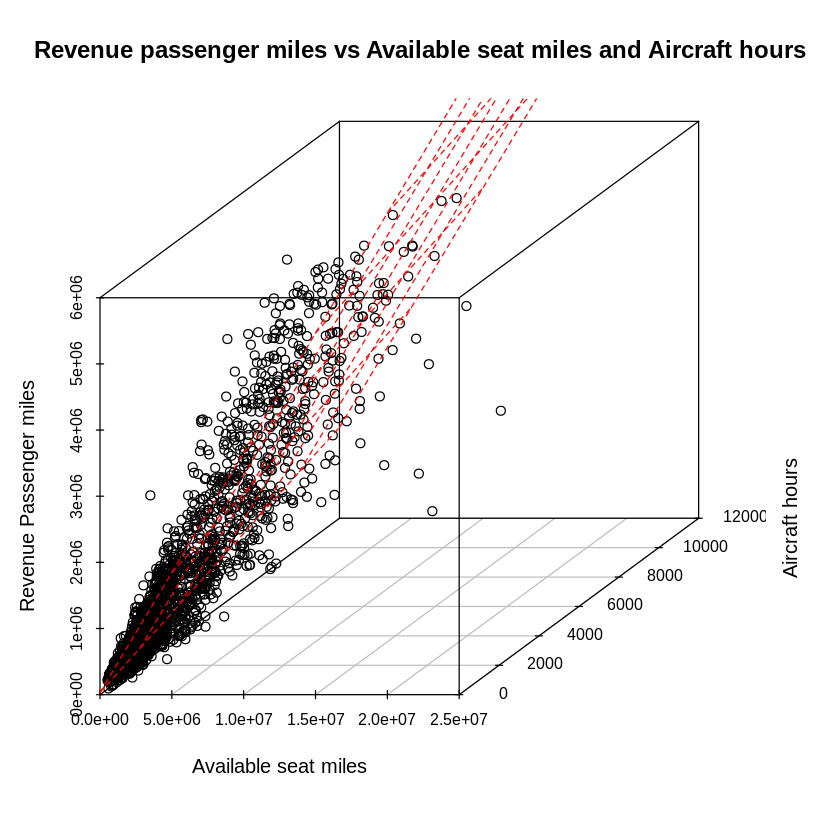

In [ ]:
# Plot the scatterplot.
plot6 <- scatterplot3d(dataset_final$AVAIL_SEAT_MILES, dataset_final$AIRCRAFT_HOURS, dataset_final$REV_PAX_MILES, main="Revenue passenger miles vs Available seat miles and Aircraft hours", xlab= "Available seat miles", ylab= "Aircraft hours", zlab="Revenue Passenger miles")

# Perform the linear regression of z on x and y.
test6 <- lm(dataset_final$REV_PAX_MILES ~ dataset_final$AVAIL_SEAT_MILES + dataset_final$AIRCRAFT_HOURS, data=dataset_final)

# Add the regression plane to the plot.
plot6$plane3d(test6, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test6)


Call:
lm(formula = dataset_final$REV_PAX_MILES ~ dataset_final$AVAIL_SEAT_MILES + 
    dataset_final$AIRCRAFT_HOURS, data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-5341094  -191144   -31931   160277  2637120 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    3.300e+04  1.753e+04   1.882   0.0599 .  
dataset_final$AVAIL_SEAT_MILES 3.623e-01  4.822e-03  75.130   <2e-16 ***
dataset_final$AIRCRAFT_HOURS   1.117e+02  1.033e+01  10.811   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 525600 on 2275 degrees of freedom
Multiple R-squared:  0.8368,	Adjusted R-squared:  0.8366 
F-statistic:  5832 on 2 and 2275 DF,  p-value: < 2.2e-16


**Analysis:**

Linear regression equation:
<br>$y=3300+0.3623x_1+10.17x_2$

In [ ]:
median(dataset_final$AVAIL_SEAT_MILES)

[1] 1526924

In [ ]:
median(dataset_final$AIRCRAFT_HOURS)

[1] 1240.5

Given our model, if an airline had 1,526,924 `Available seat miles` and 1,240.5 `Aircraft hours`, then their predicted `Revenue passenger miles` would be 569,120.

We can see in the 3D scatterplot that there seems to be a **strong positive correlation** between all three variables, as their general direction is a diagonal plane in space. The adjusted r-squared value for this model is 0.8366, meaning that 83.66% of the variance in the y-values is accounted for by the linear regression model. 

This is the highest we've seen so far, beating the `Revenue passenger miles` vs `Available seat miles` simple linear regression by about 0.05, since the SLR r-squared value was  0.8283.

Therefore, we **confidently and accurately predict** the `Revenue passenger miles` from `Available seat miles` + `Aircraft hours`. In addition, this MLR is **superior** to the earlier SLR `Revenue passenger miles` vs `Available seat miles`.

---

## 2. Revenue ton miles vs Available ton miles + Aircraft miles

**Prediction:**
<br> How well can we predict the amount of `Revenue ton miles` generated by an airline, given their `Available ton miles` and `Aircraft miles`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

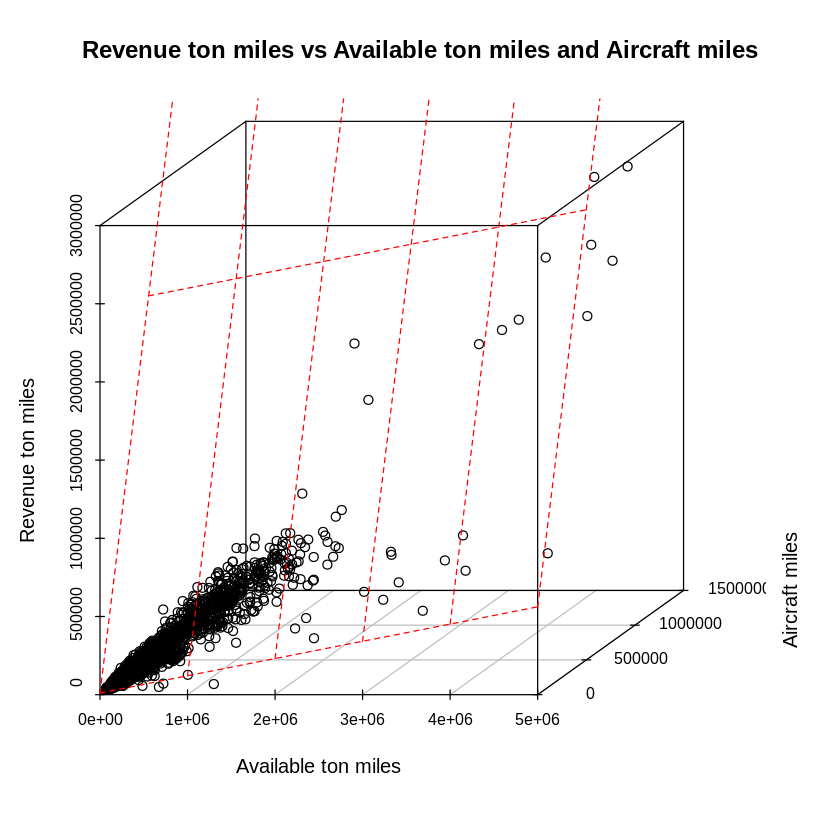

In [ ]:
# Plot the scatterplot.
plot7 <- scatterplot3d(dataset_final$AVAIL_TON_MILES, dataset_final$AIRCRAFT_MILES, dataset_final$REV_TON_MILES, main="Revenue ton miles vs Available ton miles and Aircraft miles", xlab= "Available ton miles", ylab= "Aircraft miles", zlab="Revenue ton miles")

# Perform the linear regression of z on x and y.
test7 <- lm(dataset_final$REV_PAX_MILES ~ dataset_final$AVAIL_TON_MILES + dataset_final$AIRCRAFT_MILES, data=dataset_final)

# Add the regression plane to the plot.
plot7$plane3d(test7, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test7)


Call:
lm(formula = dataset_final$REV_PAX_MILES ~ dataset_final$AVAIL_TON_MILES + 
    dataset_final$AIRCRAFT_MILES, data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-7297899  -309542   -66249   216922  2817001 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   1.076e+04  2.522e+04   0.427   0.6696    
dataset_final$AVAIL_TON_MILES 1.102e-01  5.748e-02   1.916   0.0555 .  
dataset_final$AIRCRAFT_MILES  4.635e+00  1.155e-01  40.116   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 768500 on 2275 degrees of freedom
Multiple R-squared:  0.6511,	Adjusted R-squared:  0.6508 
F-statistic:  2123 on 2 and 2275 DF,  p-value: < 2.2e-16


**Analysis:**

Linear regression equation:
<br>$y=1076+0.1102x_1+4.635x_2$

In [ ]:
median(dataset_final$AVAIL_TON_MILES)

[1] 175792

In [ ]:
median(dataset_final$AIRCRAFT_MILES)

[1] 174088

Given our model, if an airline had 175,792 `Available ton miles` and 174,088 `Aircraft miles`, then their predicted `Revenue ton miles` would be 827,436.

We can notice a **moderate positive correlation** between all three variables. The adjusted r-squared value for this model is 0.6508, meaning that 65.08% of the variance in the y-values is accounted for by the linear regression model. 

This means that adding `Aircraft hours` as another predictor variable lowered the accuracy of our predictions, since the simple linear regression between `Revenue ton miles` and `Available ton miles` had an adjusted r-squared of 0.7961, which is 0.1453 higher.

We can conclude that there is a moderate positive correlation between `Available ton miles`, `Aircraft miles`, and `Revenue ton miles`. 

In addition, we can conclude that this MLR is **inferior** to the earlier SLR comparing `Revenue ton miles` and `Available ton miles`.

---

## 3. Revenue unit miles vs Available seat miles + Available ton miles

**Prediction:**
<br> How well can we predict the amount of `Revenue unit miles` generated by an airline, given their `Available seat miles` and `Available ton miles`?

**Method:**
<br>Plot the scatter plot and linear regression, then print the regression summary.

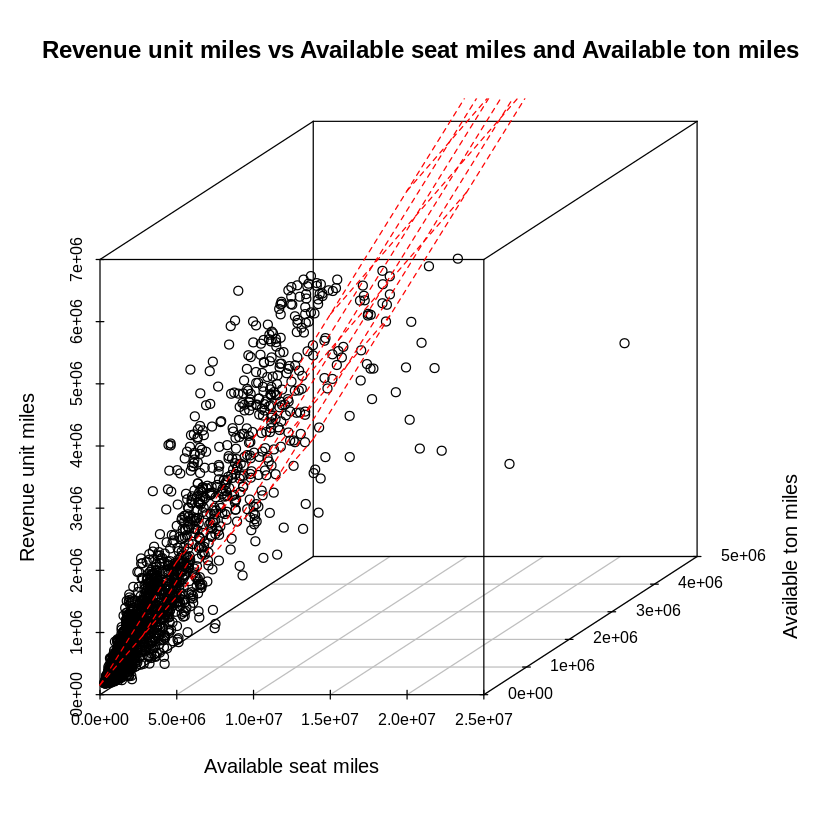

In [ ]:
# Plot the scatterplot.
plot8 <- scatterplot3d(dataset_final$AVAIL_SEAT_MILES, dataset_final$AVAIL_TON_MILES, dataset_final$REV_UNIT_MILES, main="Revenue unit miles vs Available seat miles and Available ton miles", xlab= "Available seat miles", ylab= "Available ton miles", zlab="Revenue unit miles")

# Perform the linear regression of z on x and y.
test8 <- lm(dataset_final$REV_UNIT_MILES ~ dataset_final$AVAIL_SEAT_MILES + dataset_final$AVAIL_TON_MILES, data=dataset_final)

# Add the regression plane to the plot.
plot8$plane3d(test8, col="red")

In [ ]:
# Print the summary of the linear regression.
summary(test8)


Call:
lm(formula = dataset_final$REV_UNIT_MILES ~ dataset_final$AVAIL_SEAT_MILES + 
    dataset_final$AVAIL_TON_MILES, data = dataset_final)

Residuals:
     Min       1Q   Median       3Q      Max 
-6906706  -208325   -62164   159194  2982203 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.555e+05  1.712e+04   9.083   <2e-16 ***
dataset_final$AVAIL_SEAT_MILES 3.975e-01  5.954e-03  66.764   <2e-16 ***
dataset_final$AVAIL_TON_MILES  3.466e-01  4.057e-02   8.543   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 590600 on 2275 degrees of freedom
Multiple R-squared:  0.8295,	Adjusted R-squared:  0.8293 
F-statistic:  5532 on 2 and 2275 DF,  p-value: < 2.2e-16


**Analysis:**

Linear regression equation:
<br>$y=15550+0.3975x_1+0.3466x_2$

In [ ]:
median(dataset_final$AVAIL_SEAT_MILES)

[1] 1526924

In [ ]:
median(dataset_final$AVAIL_TON_MILES)

[1] 175792

Given our model, if an airline had 1,526,924 `Available seat miles` and 175,792 `Available ton miles`, then their predicted `Revenue unit miles` would be 683,431.

In the scatterplot, we notice again that points are all clustered in a straight diagonal cone through space. This shows that the three variables are all **strongly positively correlated**. The adjusted r-squared value for this model is 0.8293, meaning that 82.93% of the variance in the y-values is accounted for by the linear regression model. 

Compared to our simple linear regression, `Revenue unit miles` vs `Departures performed`, the r-squared values were 0.8293 and 0.2632 respectively, meaning that this multiple linear regression is far **superior** to the simple linear regression.

Therefore, we can **confidently and accurately** predict `Revenue unit miles` given `Available seat miles` and `Available ton miles`.

---

## Comparisons between the MLRs

As mentioned earlier, our MLRs are the following:

1.   **Revenue passenger miles** vs **Available seat miles** + **Aircraft hours** | r2 = 0.8366
2.   **Revenue ton miles** vs **Available ton miles** + **Aircraft miles** | r2 = 0.6508
3.   **Revenue unit miles** vs **Available seat miles** + **Available ton miles** | r2 = 0.8293



We also previously mentioned the following:

*   MLR #1 is slightly superior to SLR #1 (0.8366 vs 0.8283)
*   MLR #2 is inferior to SLR #2 (0.6508 vs 0.7961)
*   MLR #3 is superior to SLR #3 (0.8293 vs 0.2632)






Overall, MLR #1 and #3 were successful, with high positive correlations found between the three variables, ensuring us that our model can be used for a prediction.

For `Revenue ton miles`, we will stick to predicting it with only 1 predictor variable, being `Available ton miles`, as adding `Aircraft miles` did not improve the model.

---

# Project Report

To Pacific Airlines,

We have observed and analyzed the data from the Small Air Carrier Statistics (Form 298C Traffic Data) from 1974-2002. This data was provided by the US Department of Transportation – Bureau of Transportation Statistics. In addition, our objective was to analyze Schedule A-1 to see the public record of metrics from airline companies' such as departures, seats, miles, and revenue miles generated. We would like to present our methods and findings.

The dataset first had to be cleaned, by removing irrelevant columns such as `Sch Departures` and `Comp Departures`. Then, we removed all entries that had empty values, or NA. We then removed outliers in the data below the 15th percentile and above the 85th percentile, in order to eliminate the noise for our plots and regressions.

During exploration of the data, we found that our dataset had 4070 entries, and found the average off each of the metrics for all airline companies. In addition, we viewed a histogram of the number of departures performed by airlines, showing that most airline companies were between 0-10,000 `Departures performed`.

In [ ]:
# View the averages for every column.
means

DEP_PERFORMED,AVAIL_TON_MILES,AVAIL_SEAT_MILES,REV_PAX_MILES,REV_TON_MILES,AIRCRAFT_MILES,AIRCRAFT_HOURS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3534.158,756128.8,5673009,2564247,315406.1,5673009,2522.411


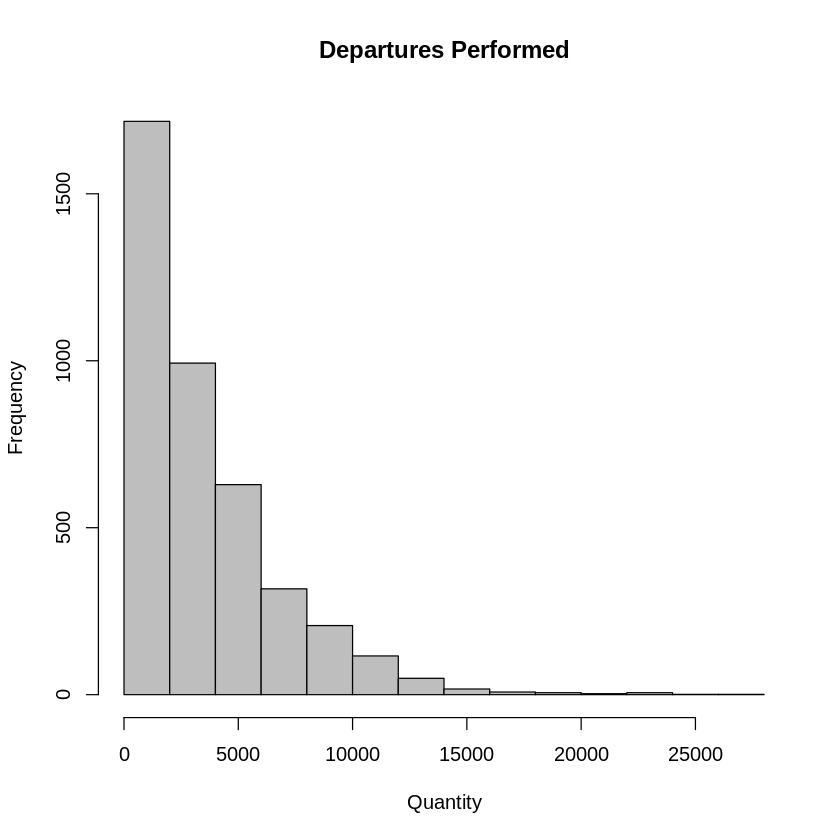

In [ ]:
# Plot a histogram of departures performed.
hist.dep.performed <- hist(dataset_v3$DEP_PERFORMED, freq=TRUE, col="grey", 
     xlab="Quantity", main="Departures Performed")

Next, defined a new term: a **unit**, which refers to **1 passenger** or **1 ton** of freight. This was necessary because Schedule A-1 does not specify how many total aircraft miles were travelled with passengers and with freight, and there may have flights that are a mix of the two as well. We then adapted `Revenue unit miles`, `Available units per flight`, `Units sold per flight`, and `Load factor` into the dataset before cleaning outliers out again. 
<br>Below you can view a summary of all airlines' `Revenue unit miles`.

In [ ]:
summary(dataset_v4$REV_UNIT_MILES)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     3356    280703    838031   2879653   3308337 250366975 

Next, we wanted to **visualize** some of our variables and compare them to each other. For example, we were able to see that the number of `units sold per flight` was roughly about **half** of the amount of `units available per flight` on average. 

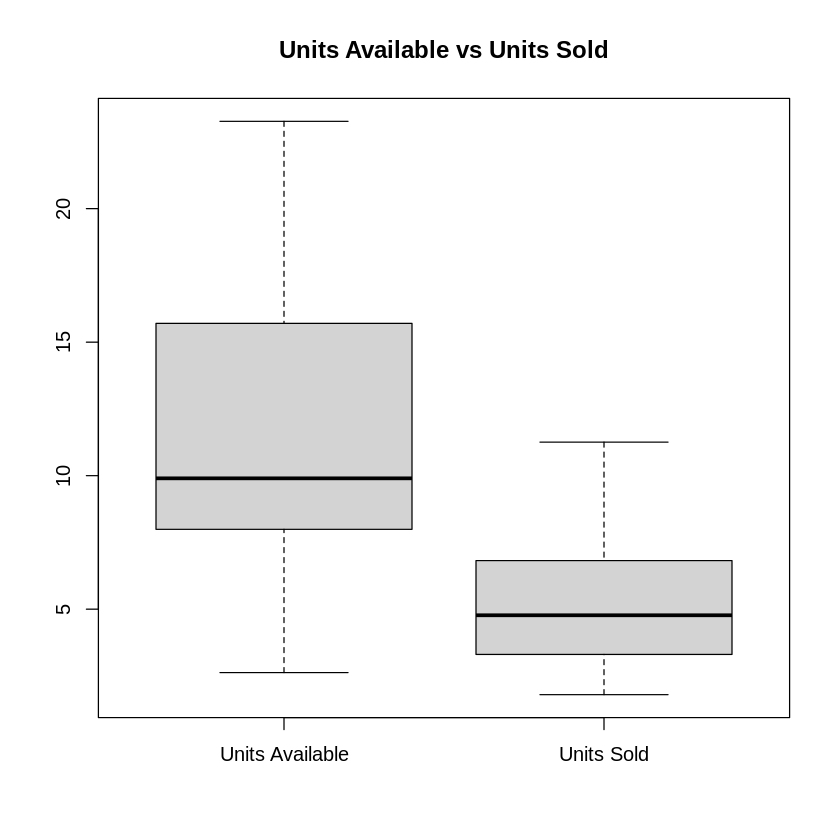

In [ ]:
boxplot(dataset_final$AVAIL_UNITS, dataset_final$UNITS_SOLD, horizontal=FALSE, names=c('Units Available', 'Units Sold'), main='Units Available vs Units Sold')

We further confirmed this by viewing a barplot of `Load factor`, a metric which measures the % capacity of an airline being used per given flight. Below, we noticed that typical airlines are **between 0.4-0.6** `Load factor`.

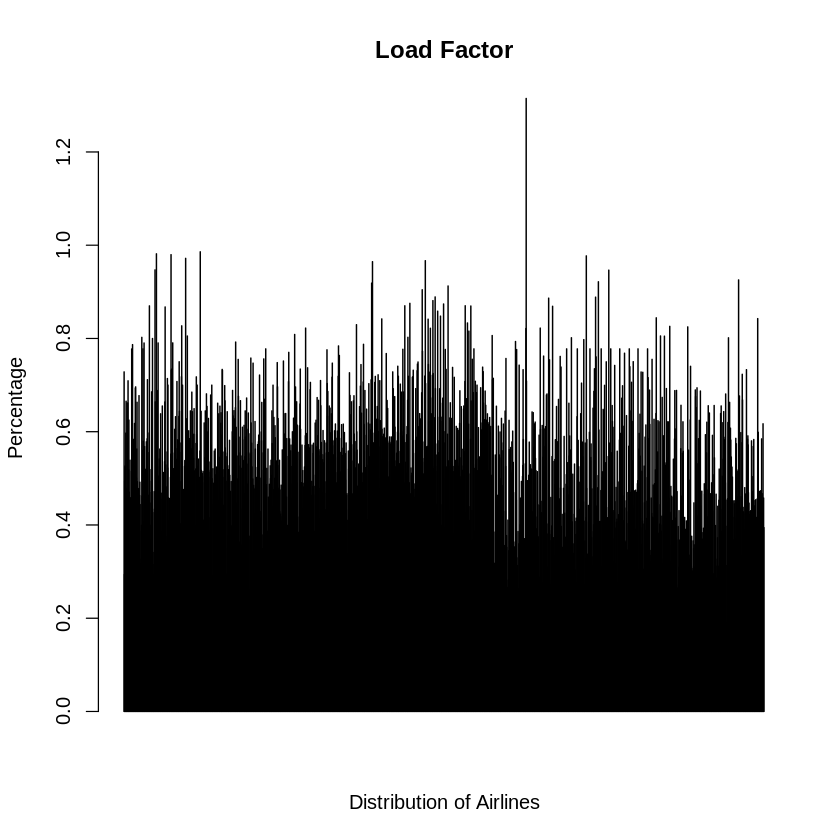

In [ ]:
barplot(dataset_final$LOAD_FACTOR, xlab='Distribution of Airlines', ylab='Percentage', main='Load Factor')

With our final dataset completed, we set out to explore correlations between some of the **predictors**. For example, we found a positive correlation between `Aircraft Hours` and `Aircraft Miles`.

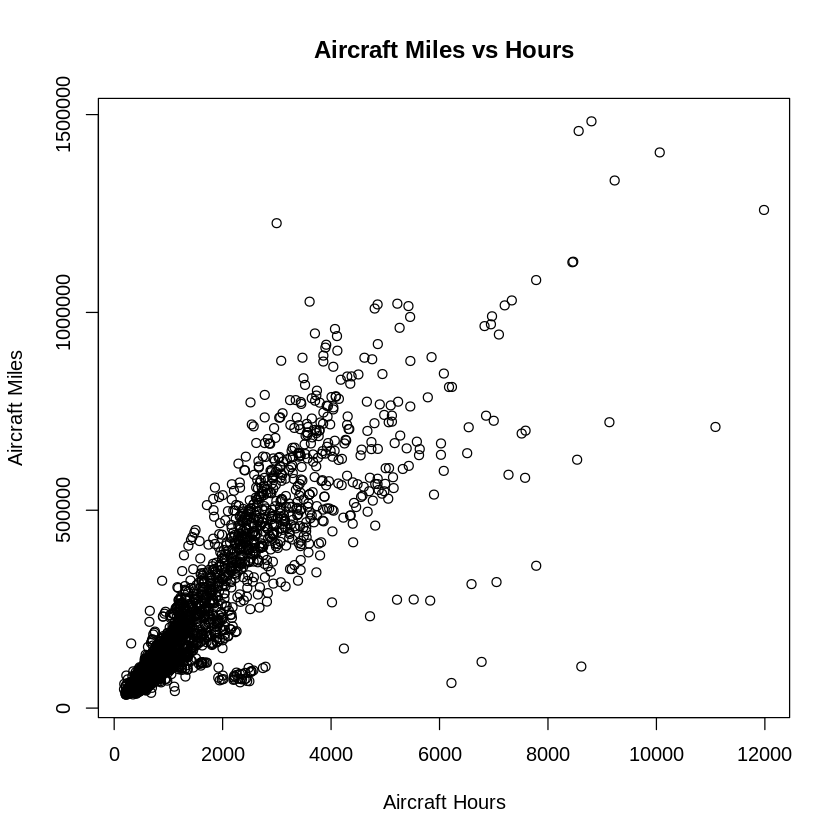

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AIRCRAFT_HOURS, dataset_final$AIRCRAFT_MILES, xlab='Aircraft Hours', ylab='Aircraft Miles', main='Aircraft Miles vs Hours')

At the same time, we found no correlation between the amount of `Departures performed` and the `Available units for sale`.

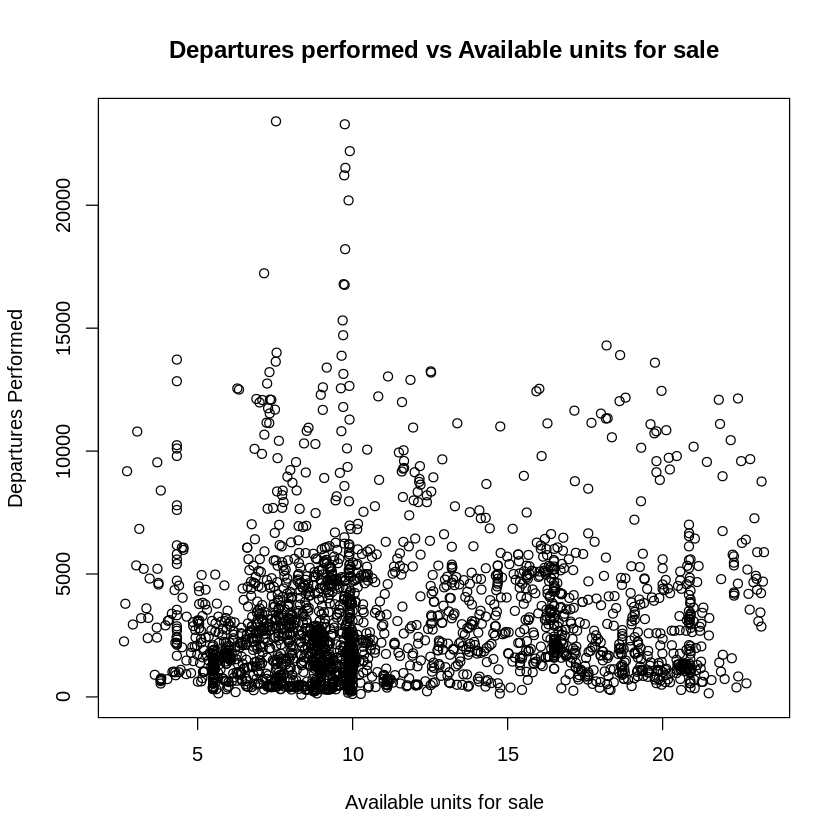

In [ ]:
# Plot the scatterplot.
plot(dataset_final$AVAIL_UNITS, dataset_final$DEP_PERFORMED, xlab= 'Available units for sale', ylab= 'Departures Performed', main='Departures performed vs Available units for sale')

Finally, we performed linear regressions on our variables, trying to predict dependent variables such as:


*   Revenue passenger miles (SLR, MLR)
*   Revenue ton miles (SLR, MLR)
*   Revenue unit miles (SLR, MLR)
*   Units sold per flight (SLR only)
*   Load factor (SLR only)








We sought to answer the following:

"How well can we predict the amount of **revenue miles** an airline can generate, given inputs such as the amount of **departures** they perform, and the amount of available **capacity** that they have?"

We discovered that there were strong linear correlations that could be used to predict `Revenue passenger miles`, `Revenue ton miles`, and `Revenue unit miles`.
<br>As for `Units sold per flight` and `Load factor`, we found weak correlations that made it difficult to predict their values given our inputs. 
<br> Essentially, we **can** predict how many revenue miles can be generated per quarter given how much an airline flies, but we **cannot** predict how many passengers will buy seats.

Let's look at our linear regression model for `Revenue unit miles`. This is a metric that combines `Revenue passenger miles` and `Revenue ton miles`, essentially combining the revenue of both passenger and freight service.

Firstly, let's view the scatterplot and regression line when using `Departures performed` as our input.

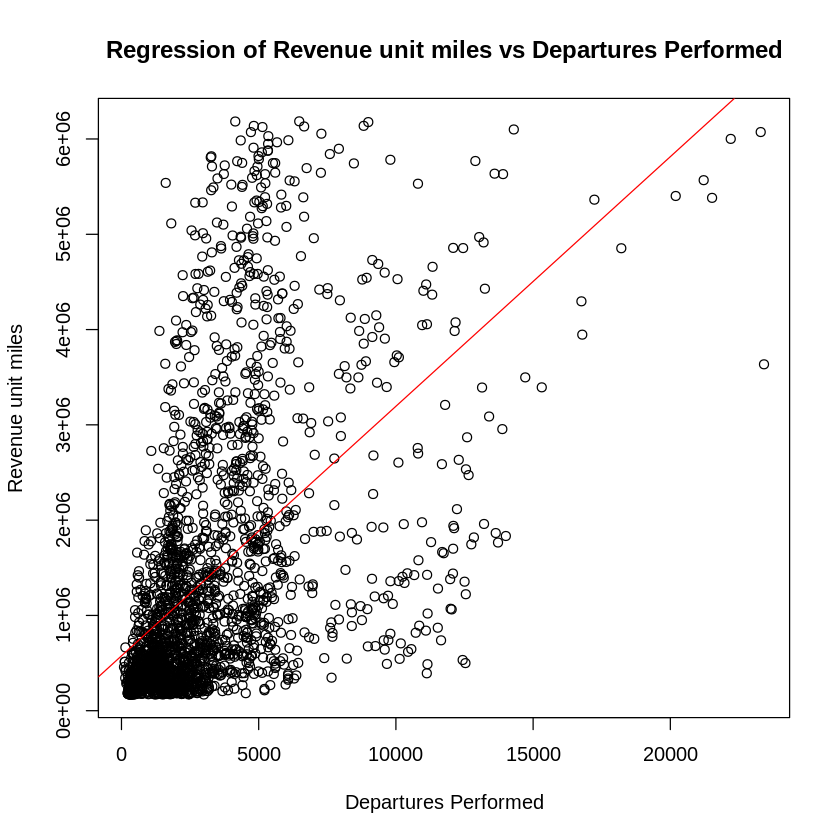

In [ ]:
# Plot the scatterplot.
plot(dataset_final$DEP_PERFORMED, dataset_final$REV_UNIT_MILES, main="Regression of Revenue unit miles vs Departures Performed", xlab= "Departures Performed", ylab= "Revenue unit miles")

# Add the regression line to the plot.
abline(test3, col="red")

We can see a moderately strong correlation between the two variables. 

Given  a regression equation of $y = 575686.89 + 261.95x$, and a median `Departures performed` of 2346, we were able to predict that a typical airline who performs 2346 departures would generate 1,190,352 `Revenue unit miles`.

Now, let's view the multiple linear regression for `Revenue unit miles`. This time, we'll be using `Available seat miles` and `Available ton miles` as our predictor.

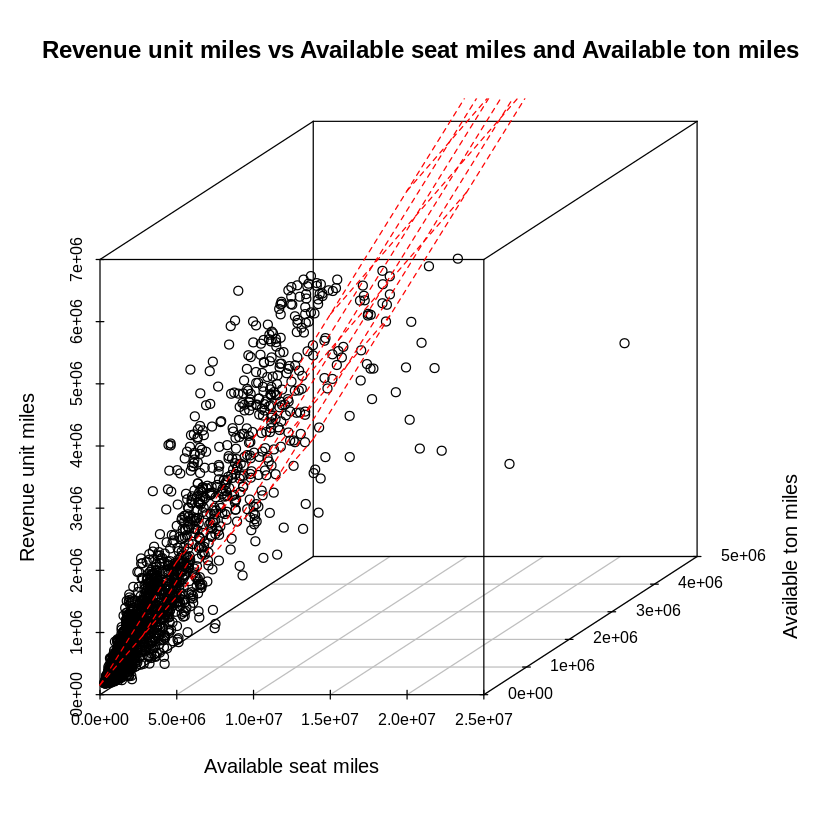

In [ ]:
# Plot the scatterplot.
plot8 <- scatterplot3d(dataset_final$AVAIL_SEAT_MILES, dataset_final$AVAIL_TON_MILES, dataset_final$REV_UNIT_MILES, main="Revenue unit miles vs Available seat miles and Available ton miles", xlab= "Available seat miles", ylab= "Available ton miles", zlab="Revenue unit miles")

# Add the regression plane to the plot.
plot8$plane3d(test8, col="red")

We can see a strong positive correlation between the three variables, meaning we can accurately predict `Revenue unit miles`.

Given our regression equation $y=15550+0.3975x_1+0.3466x_2$, and the fact that a typical airline has 1526924 `Available seat miles` and 175792 `Available ton miles`, their predicted `Revenue unit miles` is 683,431.

We also performed more simple & multiple linear regressions on other variables, which can be found in the report. However, we decided to display our predictions `Revenue unit miles` in our summary as we believe that is the most pertinent question at hand right now.

In conclusion, we have explored and analyzed the data on Small Air Carrier Statistics (Form 298C Traffic Data), Schedule A-1 and now have a greater understanding of a few things:

1.   Most small air carriers today operate between 0-10,000 departures per quarter, with most being highly clustered in 0-5,000 departures. We can clearly see that as departures increase, there are much less airlines being able to provide that level of service.
2.   The % of seats/tons sold compared to the available capacity is typically about 40-60% for most airlines. However, there are still some airlines that can reach close to 100% capacity utilized.
3.   We can confidently predict revenue passenger miles, revenue ton miles, and revenue unit miles given the amount of departures performed or miles flown. Therefore, should Pacific Airlines have an idea of the amount of miles they want their total fleet to travel, they will also be able to know how many revenue miles they can generate.
4.   We cannot confidently predict load factor or # of units sold per flight given any inputs. We do not know how successful a company can be at selling tickets and selling out all their seats or freight capacity given our current inputs.









This concludes our report. Thank you for reading our analysis on Small Aircraft Carriers.

Jonathan Tang

---